# Evaluate impact of damage function shape

In [1]:
# Copyright 2023 Richard Laugesen

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     https://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import bz2

sys.path.append('..')

from ruv.relative_utility_value import *
from ruv.damage_functions import *
from ruv.economic_models import *
from ruv.utility_functions import *

In [2]:
plt.rcParams['figure.figsize'] = (8, 7)

plt.rcParams['font.family'] = "arial"
plt.rcParams['font.size'] = "12.5"

colors = {
    'black': '#000000',
    'light_orange': '#E69F00',
    'light_blue': '#56B4E9',
    'green': '#009E73',
    'yellow': '#F0E442',
    'dark blue': '#0072B2',
    'dark_orange': '#D55E00',
    'pink': '#CC79A7'
} 

# Example forecast dataset
### Day 1 to 7 forecasts for catchment in southern Murray-Darling basin generated using the MuTHRE method

In [3]:
awrc = '405219'
dataset_filepath = '%s_data.pickle.bz2' % awrc
parallel_nodes = 6
k_step = 0.02

In [9]:
with bz2.BZ2File(dataset_filepath, 'r') as f:
    data = pickle.load(f)
obs, clim_ens, fcst_ens = data['obs'], data['clim'], data['fcst']
print(obs.shape, fcst_ens.shape, clim_ens.shape)

(1932,) (1932, 100) (1932, 497)


# Define decision context

In [5]:
decision_definition = {
    'econ_pars': np.array([0.1, 0.5, 0.9]),
    'utility_function': [cara, {'A': 0.3}],                                  # minor risk aversion
    'economic_model': [cost_loss, cost_loss_analytical_spend],
    'decision_thresholds': None,
    'decision_method': 'optimise_over_forecast_distribution',
    'damage_function': [logistic, {'k': 1, 'A': 1, 'threshold': np.nanquantile(obs, 0.99)}]
}

ref = clim_ens  # use 14-day moving average climatology as the reference forecast

# Plot sample damage functions

In [6]:
ks = np.exp(np.arange(0, 2, k_step)) - 1
ks = np.append(ks, [10, 50, 100])     # add few more value closers to a step function


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "C:\Users\me\AppData\Local\Programs\Python\Python312\Lib\bdb.py", line 342, in set_trace
    sys.settrace(self.trace_dispatch)



> c:\users\me\appdata\local\temp\ipykernel_35272\1419772741.py(4)<module>()




PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "C:\Users\me\AppData\Local\Programs\Python\Python312\Lib\bdb.py", line 353, in set_continue
    sys.settrace(None)



> c:\users\me\appdata\local\temp\ipykernel_35272\1419772741.py(4)<module>()

> c:\users\me\appdata\local\temp\ipykernel_35272\1419772741.py(4)<module>()

{'k': np.float64(1.7731947639642978), 'A': 1, 'threshold': np.float64(9.685894092222528)}
array([3.47538068e-08, 3.53755556e-08, 3.60084275e-08, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00])
[3.47538068e-08 3.53755556e-08 3.60084275e-08 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
[3.47538068e-08 3.53755556e-08 3.60084275e-08 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
[3.47538068e-08 3.53755556e-08 3.60084275e-08 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
[3.47538068e-08 3.53755556e-08 3.60084275e-08 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
[3.47538068e-08 3.53755556e-08 3.60084275e-08 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
[3.47538068e-08 3.53755556e-08 3.60084275e-08 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
[3.47538068e-08 3.53755556e-08 3.60084275e-08 ... 1.000000


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "C:\Users\me\AppData\Local\Programs\Python\Python312\Lib\bdb.py", line 367, in set_quit
    sys.settrace(None)



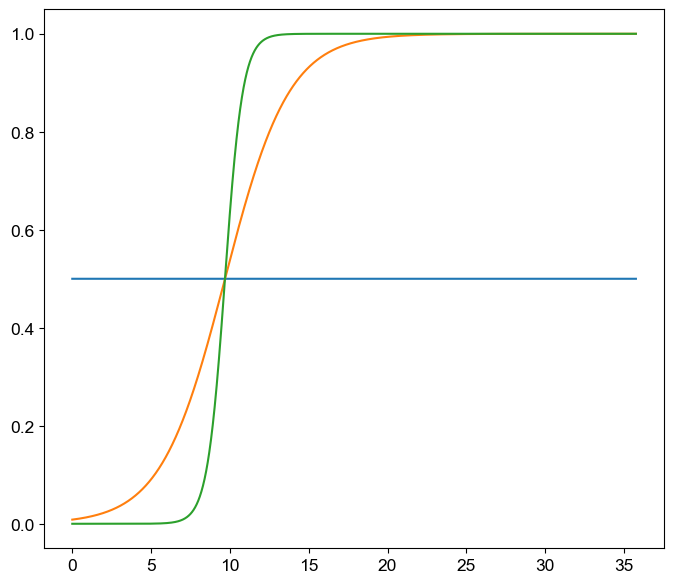

In [10]:
streamflow = np.arange(0, np.nanmax(obs) * 1.3, 0.01)
damage_fnc, params = decision_definition['damage_function']

for k in ks[[0, 20, int(len(ks)/2), len(ks)-1]]:
    params['k'] = k
    damages = damage_fnc(params)(streamflow)
    plt.plot(streamflow, damages, label='k=%.1f' % params['k'])

plt.axvline(np.nanmax(obs), color='red', linewidth=0.5, alpha=0.5, linestyle='dotted', label='Max obs')

plt.title('Example damage functions different damage function steepness')
plt.xlabel('Streamflow')
plt.ylabel('Damages')
plt.legend()

# Calculate RUV for the different shape logistic damage functions

In [8]:
results = {}
for k in ks:
    decision_definition['damage_function'] = [logistic, {'k': k, 'A': 1, 'threshold': np.nanquantile(obs, 0.99)}]
    results[k] = relative_utility_value(obs, fcst_ens, ref, decision_definition, parallel_nodes=parallel_nodes)['ruv']

results_df = pd.DataFrame(results, index=decision_definition['alphas']).T

KeyboardInterrupt: 

# Plot results for different values of alpha

In [ ]:
results_df.plot()
plt.axhline(0, color='grey', linewidth=0.5, alpha=0.3, linestyle='dotted')
plt.ylim(-0.05, 1)
plt.xlim((0, 4.5))

plt.xlabel('Logistic steepness parameter (k)')
plt.ylabel('Forecast value (RUV)')
plt.title('Impact of damage function steepness on forecast value for different values of alpha', fontsize='medium')
plt.legend()